# Land Parcel Identification System (LPIS) prediction for Slovenia

This notebook shows the steps towards constructing machine learning model for LPIS prediction for Slovenia.

### Overview

#### Requirements
1. Downloaded and processed Sentinel data *(relevant [notebook](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb))*
    * Sentinel-2 data download
    * cloud detection and masking
    * interpolation    
    

2. Downloaded and grouped LPIS data *(relevant [notebook](LPISDataFromGeopedija.ipynb))*
    * LPIS data download
    * LPIS class grouping 
    
#### Samples construction
1. Data sample construction
    * edge mask construction
    * oversampling
2. Feature calculation
    * stream feature calculation
    * elevation
    
#### Feature selection and model construction
1. Feature selection
    * FASTENER
2. Model construction
    * data normalization
    * model training
    * model testing
3. Model usage
    * prediction of LPIS on chosen region



In [1]:
# Firstly, some necessary imports
import os
import numpy as np
import pandas as pd
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
seed = 42
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from joblib import dump, load
from sklearn import tree
from collections import Counter

# Code that is currently in the "notebook_temporary" folder is supposed to be at some point included in the eo-learn
from notebook_temporary.edge_extraction import EdgeExtractionTask  
from notebook_temporary.sampling import BalancedClassSampler, \
    BalancedClassSamplerTask
from notebook_temporary.temporal_features import ValeroWorkflow
from notebook_temporary.utilities import AddBaseFeatures, class_name_color, draw_histogram

from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, EOWorkflow
from eolearn.io import SentinelHubDemTask

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Samples construction

### Edge mask calculation
When training the classifier we don't want to include the pixels on the borders of parcels. These pixels are potential mixed-class instances that can have a negative effect on the learning process. So prior to sampling we will construct an timeless mask which excludes the edges. This is already done in an EOTask so we just need to call it.

Since we will be classificating crops we will calculate edges based on the NDVI metric and the green band. Along those, let's calculate all the metrics that we will be needing later which are the other base bands red, green, blue, NIR (Near infra red) and the vegetation related indices NIR, ARVI, EVI, NDVI, NDWI, SIPI and SAVI.

In [2]:
base = AddBaseFeatures()
edges = EdgeExtractionTask(features={FeatureType.DATA: ['NDVI', 'BLUE']})

# This tutorial assumes all the patches are saved in current directory in folder patches. You can change this here
load_path = r'D:\Users\Beno\PycharmProjects\PerceptiveSentinel\Notebooks\test_folder\out_patches'
save_path = load_path # f'{os.path.abspath(os.getcwd())}{os.sep}patches_output'
load = LoadTask(load_path)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
save = SaveTask(save_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

execution_args = []
for name in next(os.walk(load_path))[1]:
    execution_args.append({
        load: {'eopatch_folder': name},
        save: {'eopatch_folder': name}
    })

workflow = LinearWorkflow(load,
                          base,
                          edges,
                          save)

#for e in execution_args:
#    workflow.execute(e)

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


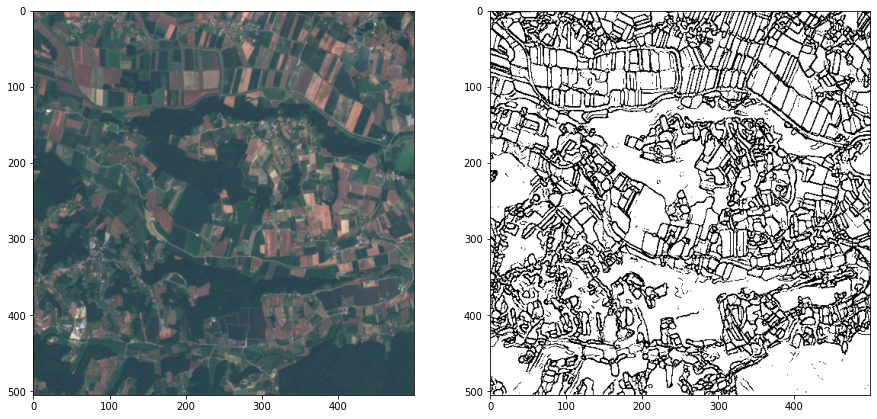

In [3]:
# Visualize the mask
patch_name = next(os.walk(save_path))[1][0]
eopatch = EOPatch.load(f'{save_path}/{patch_name}')

edges = eopatch.mask_timeless['EDGES_INV'].squeeze()
img = np.clip(eopatch.data['BANDS'][10][..., [3, 2, 1]] * 3.5, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img)
ax[1].imshow(edges, cmap='gray')
plt.show()

### Sampling
We don't want to train a classifier on every point as earth observation data can be very large and thus unfeasible. In this step we will choose a sample of the area. The properties of a sample should be that it is taken from all region uniformly and because we are training a classifier we want to have each class represented equally. This can be done with the BalancedClassSampler task. We will also exclude the the edge regions we calculated before to have a "clean" sample.

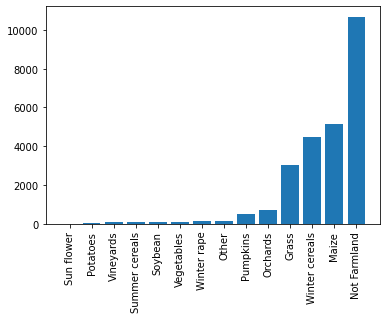

In [4]:
class_feature = (FeatureType.MASK_TIMELESS, 'LPIS_2017_G2')
sampler = BalancedClassSampler(class_feature=class_feature,
                               valid_mask=(FeatureType.MASK_TIMELESS, 'EDGES_INV'),
                               seed=seed)
sampler.sample_folder(save_path, lazy_loading=True)
distribution = sampler.get_prior_class_distribution()

# sorting so we can easier see which classes are less represented
distribution = {k: v for k, v in sorted(distribution.items(), key=lambda item: item[1])}

# Lets display what was sampled
draw_histogram(distribution)

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


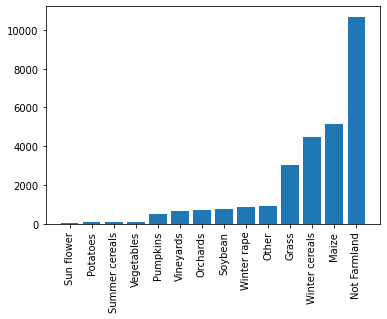

In [5]:
# As some classes are really badly represented we will do additional sampling around those
sampler2 = BalancedClassSampler(class_feature=class_feature,
                                valid_mask=(FeatureType.MASK_TIMELESS, 'EDGES_INV'),
                                seed=seed,
                                weak_classes=[10, 6, 12, 8, 14, 4])
sampler2.sample_folder(save_path, lazy_loading=True)
distribution2 = sampler2.get_prior_class_distribution()
distribution2 = {k: v for k, v in sorted(distribution2.items(), key=lambda item: item[1])}
draw_histogram(distribution2)
samples = sampler2.get_balanced_data()

## Stream features calculation
As we didn't have stream features calculated for all data we will now compute neccesary stream features for only the points that we decided on with sampling in previous step.
We will also add height of the pixel as one of the features.

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


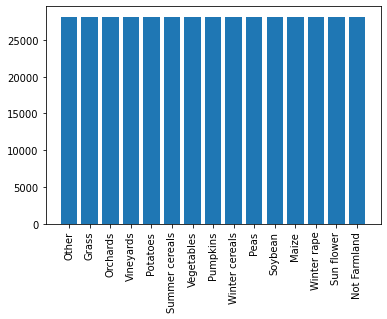

In [6]:
extended_samples = pd.read_csv('D:/Samples/review.csv')
draw_histogram(Counter(extended_samples.LPIS_2017))

In [7]:
# Assumes all the patches have same shape
# For each patch that contains any samples we will construct mask to specify where the stream
# features are computer. We don't want to compute them for the whole patch as it would take a long time
patches = next(os.walk(save_path))[1]

# Separate points by patch. Patch identifier is by default it's folder name
separated_by_patch = [(x, samples[samples['patch_identifier'] == x]) for x in patches]
execution_args = []
height = None
width = None
first_patch = True
for name, points in separated_by_patch:

    eopatch = EOPatch.load(f'{save_path}/{name}')
    height, width, _ = eopatch[class_feature].shape
    stream_mask = np.zeros((height, width), dtype=np.bool)
    if first_patch:  # Lets calculate features for all the point for the first patch so we can visualize them
        eopatch.add_feature(FeatureType.MASK_TIMELESS, 'STREAM_VALID', np.ones((height, width, 1), dtype=np.uint8))
        first_patch = False
    else:
        for x, y in zip(points['x'], points['y']):
            stream_mask[x, y] = True

        eopatch.add_feature(FeatureType.MASK_TIMELESS, 'STREAM_VALID', stream_mask[..., np.newaxis])
    eopatch.save(f'{save_path}/{name}', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [8]:
base_features = ["ARVI", "EVI", "NDVI", "NDWI", "SIPI", "SAVI", "BLUE", "RED", "NIR"]
tasks = [ValeroWorkflow(feature_name) for feature_name in base_features]
all_stream_feature_names = [n for s_task in tasks for n in s_task.feature_list()]

load = LoadTask(save_path)
if not os.path.isdir(save_path):
    os.makedirs(save_path)
save = SaveTask(save_path, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

execution_args = []
for name in next(os.walk(save_path))[1]:
    execution_args.append({
        load: {'eopatch_folder': name},
        save: {'eopatch_folder': name}
    })

# This tasks adds elevation data to the patch
dem = SentinelHubDemTask((FeatureType.DATA_TIMELESS, 'DEM'), size=(height, width))
workflow = LinearWorkflow(load,
                          dem,
                          *tasks,
                          save
                          )
#for e in execution_args:
#    workflow.execute(e)

Stream feature calculation is split into multiple (almost) independent tasks

This enables easier parallelization within the eo-library and can later be used to exclude unnecessary discarded by fastener thus greatlz increasing pre-processing speed and memory, data transer and calculation efficiency 

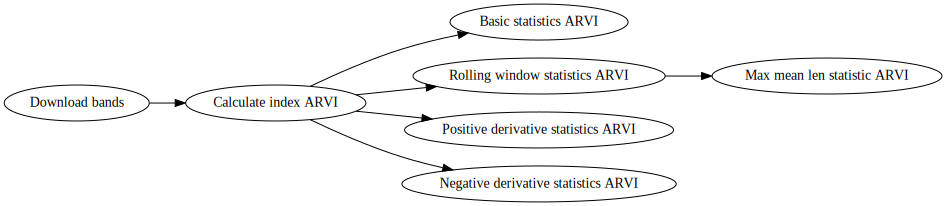

In [9]:
w = tasks[0].to_workflow()
w.dependency_graph()

Full workflow is larger, but also parallelizable for free

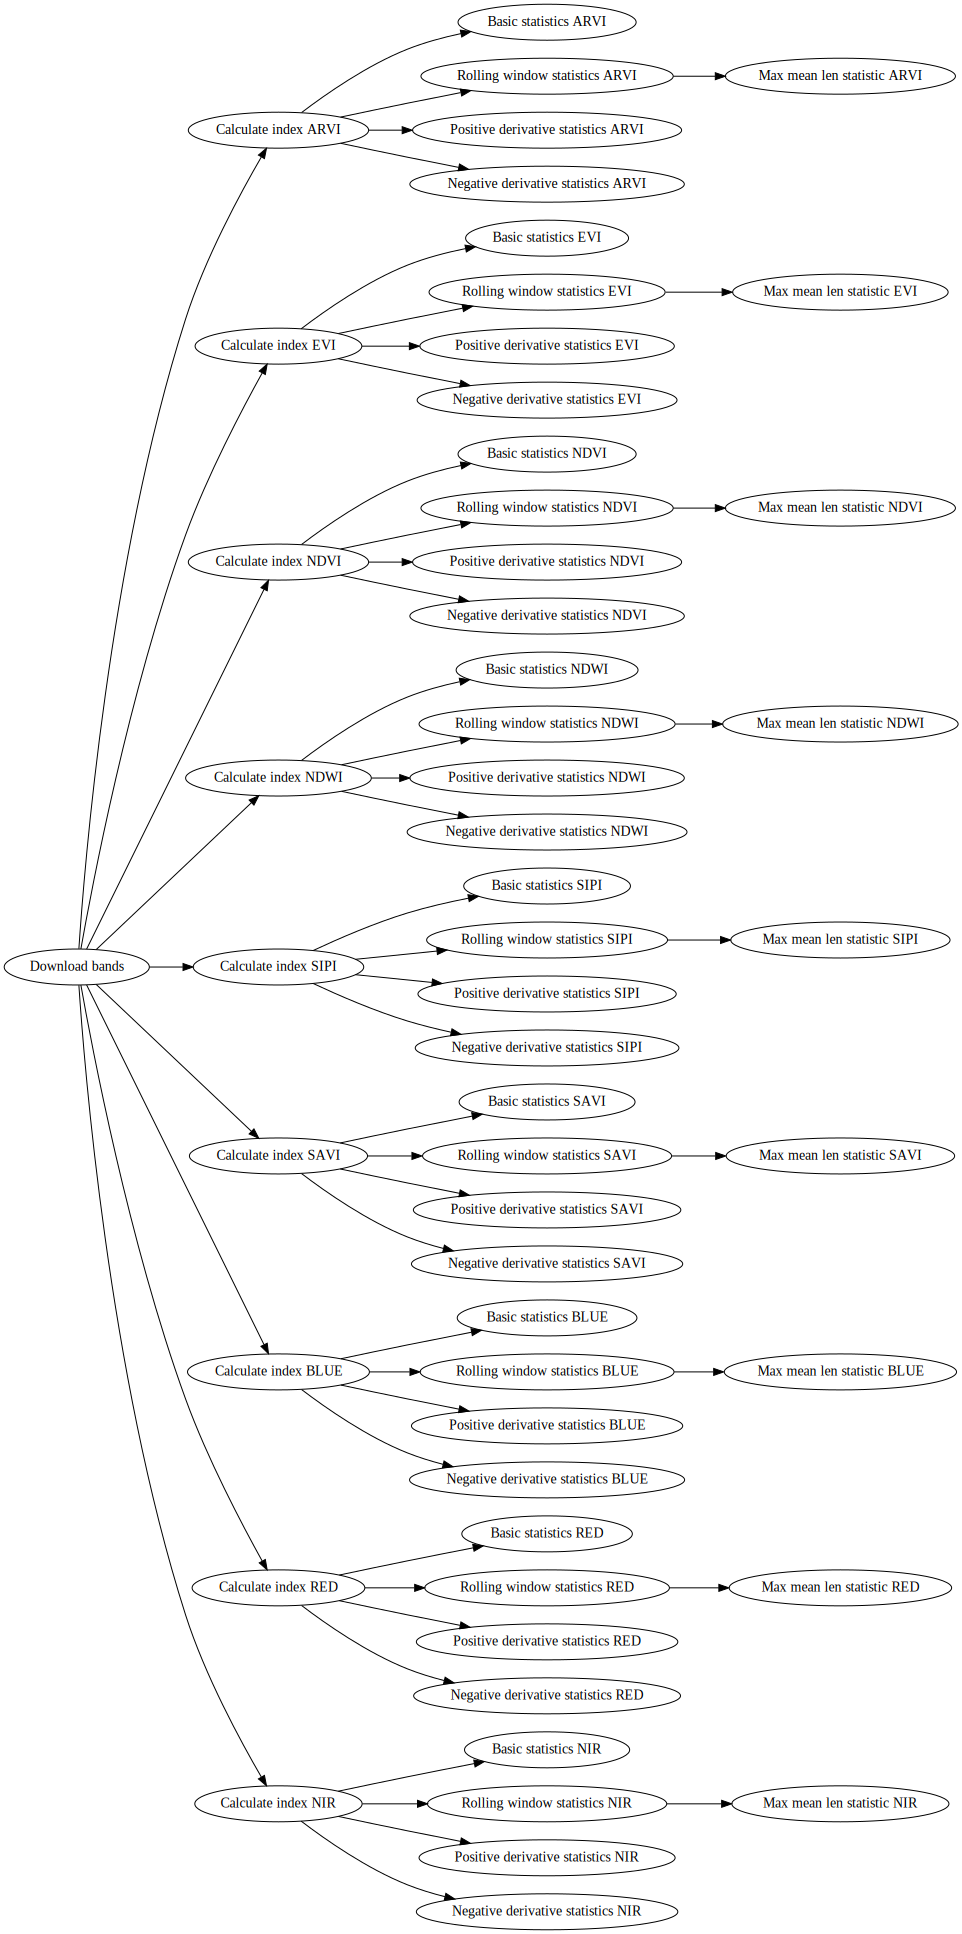

In [10]:
full_workflow_tasks = []
input_task = LoadTask(save_path)
for t in tasks:
    full_workflow_tasks.extend(t.tasks(input_task))

full_workflow = EOWorkflow(
    [(input_task, [], "Download bands"), 
     *full_workflow_tasks
    ])
full_workflow.dependency_graph()

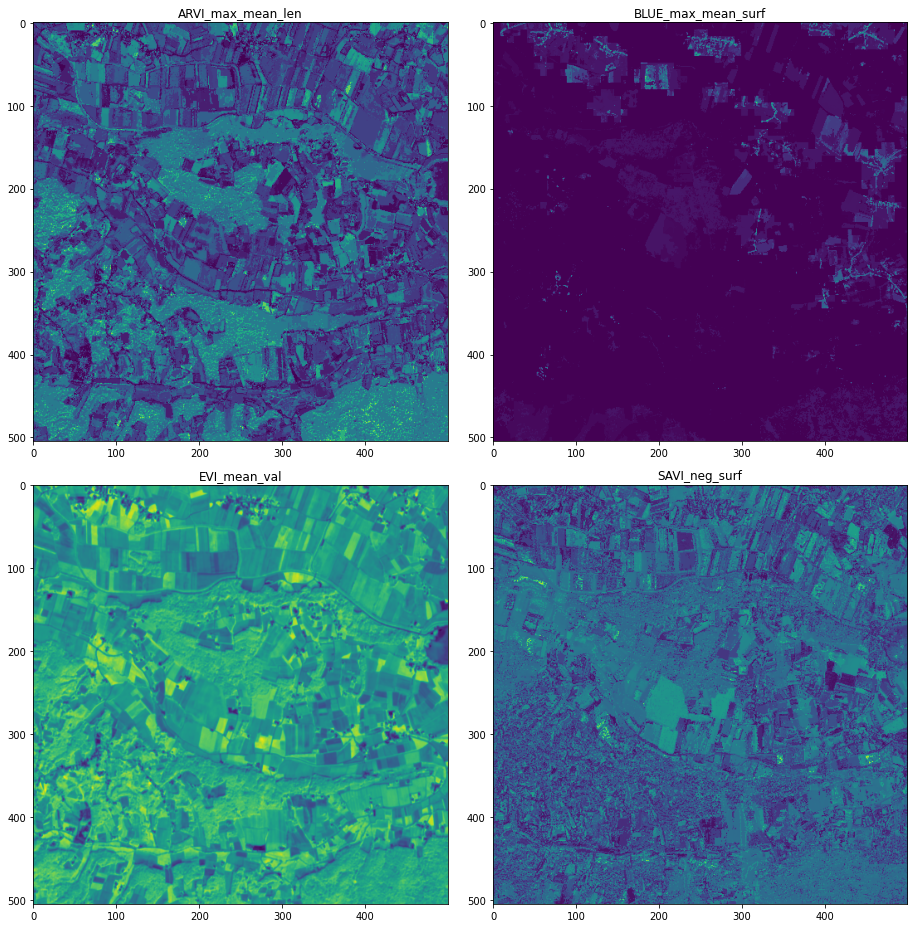

In [11]:
# Now lets visualize some features from the first patch
features_to_display = ['ARVI_max_mean_len', 'BLUE_max_mean_surf', 'EVI_mean_val', 'SAVI_neg_surf']
path = next(os.walk(save_path))[1][0]
eopatch = EOPatch.load(f'{save_path}/{path}', lazy_loading=True)
fig, ax = plt.subplots(2, 2, figsize=(13,13))
for i in range(4):
    ax[int(i / 2), i % 2].set_title(features_to_display[i])
    ax[int(i / 2), i % 2].imshow(eopatch.data_timeless[features_to_display[i]].squeeze())
plt.tight_layout()
plt.show()

In [12]:
# Once the stream features are calculated we just need to put them into the format suitable for feature selection
# we need to construct a pandas DataFrame with column names of features and the class name.
# Each row represents a single point
extended_samples = []
for name, points in separated_by_patch:
    eopatch = EOPatch.load(f'{save_path}/{name}', lazy_loading=True)
    for x, y in zip(points['x'], points['y']):
        point_data = [(class_feature[1], eopatch[class_feature][x, y, 0])] \
                     + [(f, eopatch.data_timeless[f][x, y].squeeze()) for f in all_stream_feature_names]
        extended_samples.append(dict(point_data))
extended_samples = pd.DataFrame(extended_samples)

## Feature selection and model construction
The features will be chosen using the FASTENER algorithm
## Fastener process timelapse

<IPython.core.display.Javascript object>


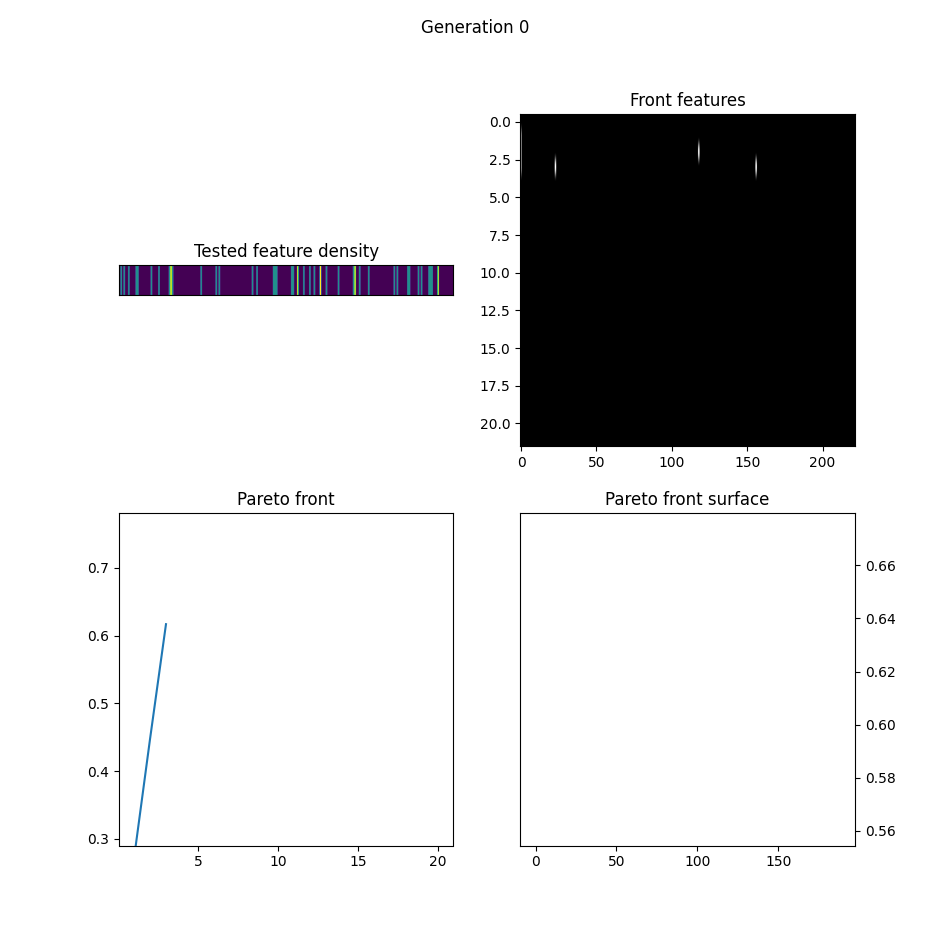

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


In [22]:
%matplotlib notebook
(front_curve_data,surface_data,tested_features,front_features,) = pickle.load(open(r"notebook_temporary\fastener_animation.pickle", "rb"))


import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from matplotlib.ticker import MaxNLocator

def to_img(ind: int):
    line = tested_features[ind, :]
    rtr = np.reshape(line / max(line), (-1, 1)).T
    return rtr

def to_front_image(ind: int):
    sq = front_features[ind]
    return sq.astype(int)

fig, ((tested_features_ax,front_img_ax), (front_ax, surface_ax)) = plt.subplots(2, 2, figsize=(9.5,9.5))

full_front_line = front_ax.plot(*front_curve_data[-1])
front_ax.set_title("Pareto front")

full_surface_line = surface_ax.plot(surface_data[:])
surface_ax.yaxis.tick_right()
surface_ax.set_title("Pareto front surface")

tested_features_line = tested_features_ax.imshow(to_img(-1), aspect=20, interpolation=None)
tested_features_ax.set_title("Tested feature density")
tested_features_ax.set_xticks([], [])
tested_features_ax.set_yticks([], [])

front_img_ax.set_title("Front features")
front_img_img = front_img_ax.imshow(to_front_image(-1), aspect=10, interpolation=None, cmap="gray")

#front_ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def animate(i):
    fig.suptitle(f"Generation {i}")
    full_front_line[0].set_data(*front_curve_data[i])
    
    full_surface_line[0].set_data(range(i), surface_data[:i])
    tested_features_line.set_data((to_img(i)))
    front_img_img.set_data(to_front_image(i))
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(front_curve_data))
plt.show()


### Model construction
Once we have final samples with selected only the best features we can train a model.

f1: 0.6936154588018159


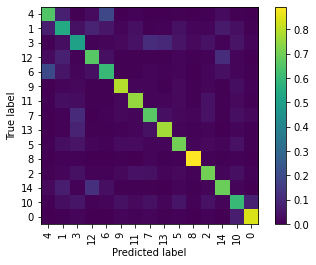

In [14]:
%matplotlib inline
extended_samples = pd.read_csv('D:/Samples/review.csv')
selected_features = ['DEM', 'ARVI_max_mean_len', 'BLUE_max_mean_surf', 'BLUE_mean_val', 'BLUE_neg_surf']
model = tree.DecisionTreeClassifier()
y = extended_samples['LPIS_2017'].to_numpy()
x = extended_samples[selected_features].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
labels = Counter(extended_samples['LPIS_2017']).keys()
no_classes = range(len(labels))
fig, ax = plt.subplots()
ax.set_ylim(bottom=0.14, top=0)
plot_confusion_matrix(model, x_test, y_test, labels=no_classes,
                      display_labels=labels,
                      cmap='viridis',
                      include_values=False,
                      xticks_rotation='vertical',
                      normalize='pred',
                      ax=ax)
f1 = f1_score(y_test, y_pred, labels=no_classes, average='macro')
print(f'f1: {f1}')
plt.show()

### Model usage on a sample region
All the features that we choose with FASTENER need to be computed

In [15]:
###### TODO Filip praktično isti klic kot zgoraj, samo da je maska IS_VALID namesto STREAM_VALID
### ubistvu se kliče samo tiste, ki so potrebni, glede na to kar je vrnu FASTENER
base_features = ["ARVI", "EVI", "NDVI", "NDWI", "SIPI", "SAVI", "BLUE", "GREEN", "RED", "NIR"]
tasks = [ValeroWorkflow(feature_name) for feature_name in base_features]
all_stream_feature_names = [n for s_task in tasks for n in s_task.feature_list()]  # 'NDVI_max_mean', 'NDVI_slope' .....

##### TODO Filip

patch_name = next(os.walk(save_path))[1][0]
load = LoadTask(patches, eopatch_folder=patch_name)
save = SaveTask(patches, eopatch_folder=patch_name, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
workflow = LinearWorkflow(load,
                          dem,
                          *tasks,
                          save)
# workflow.execute()

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Much smaller dependency graph -> faster inference time and feature calculation

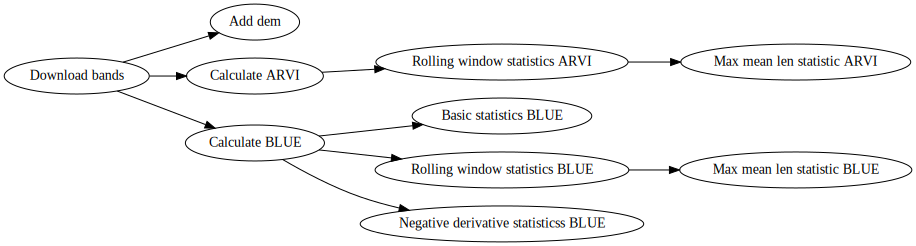

In [16]:
dg_fastener = pickle.load(open(r"notebook_temporary\LPIS_fastener_dependency_graph.pickle", "rb"))
dg_fastener

Next we need to arrange the features in the same way as we used to when training the model so they can be processed.

In [19]:
eopatch = EOPatch.load('D:/Users/Beno/PycharmProjects/PerceptiveSentinel/Notebooks/test_patch')

t, width, height, _ = eopatch.data['BANDS'].shape

x_patch = np.zeros((height * width, len(selected_features)))
i = 0
for w in range(width):
    for h in range(height):
        x_patch[i] = [float(eopatch.data_timeless[f][w][h][0]) for f in selected_features]
        i += 1

modl = pickle.load(open(r"notebook_temporary\pretrained_lpis.pickle", "rb"))
sc = pickle.load(open(r"notebook_temporary\pretrained_scaling_lpis.pickle", "rb"))
        
        
lpis = eopatch.mask_timeless['LPIS_2017_G2'].squeeze()
y_pred_patch = modl.predict(sc.transform(x_patch))

# reshape back to original shape
img = np.reshape(y_pred_patch, (width, height))

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Color scheme for coloring the classes and legend
new_classes = {0: ('Not Farmland', 'xkcd:black'),
               1: ('Grass', 'xkcd:brown'),
               2: ('Maize', 'xkcd:butter'),
               3: ('Orchards', 'xkcd:royal purple'),
               4: ('Other', 'xkcd:white'),
               5: ('Peas', 'xkcd:spring green'),
               6: ('Potatoes', 'xkcd:poo'),
               7: ('Pumpkins', 'xkcd:pumpkin'),
               8: ('Soybean', 'xkcd:baby green'),
               9: ('Summer cereals', 'xkcd:cool blue'),
               10: ('Sun flower', 'xkcd:piss yellow'),
               11: ('Vegetables', 'xkcd:bright pink'),
               12: ('Vineyards', 'xkcd:grape'),
               13: ('Winter cereals', 'xkcd:ice blue'),
               14: ('Winter rape', 'xkcd:neon blue')}

names = []
boundaries = np.zeros(15)
for i in range(15):
    names.append(new_classes[i][1])
    boundaries[i] = i - 0.5
# colormap to color with specified colors
cmap = matplotlib.colors.ListedColormap(names)
# boundaries used for color map
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

e:\programdata\anaconda3\envs\filip_final\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


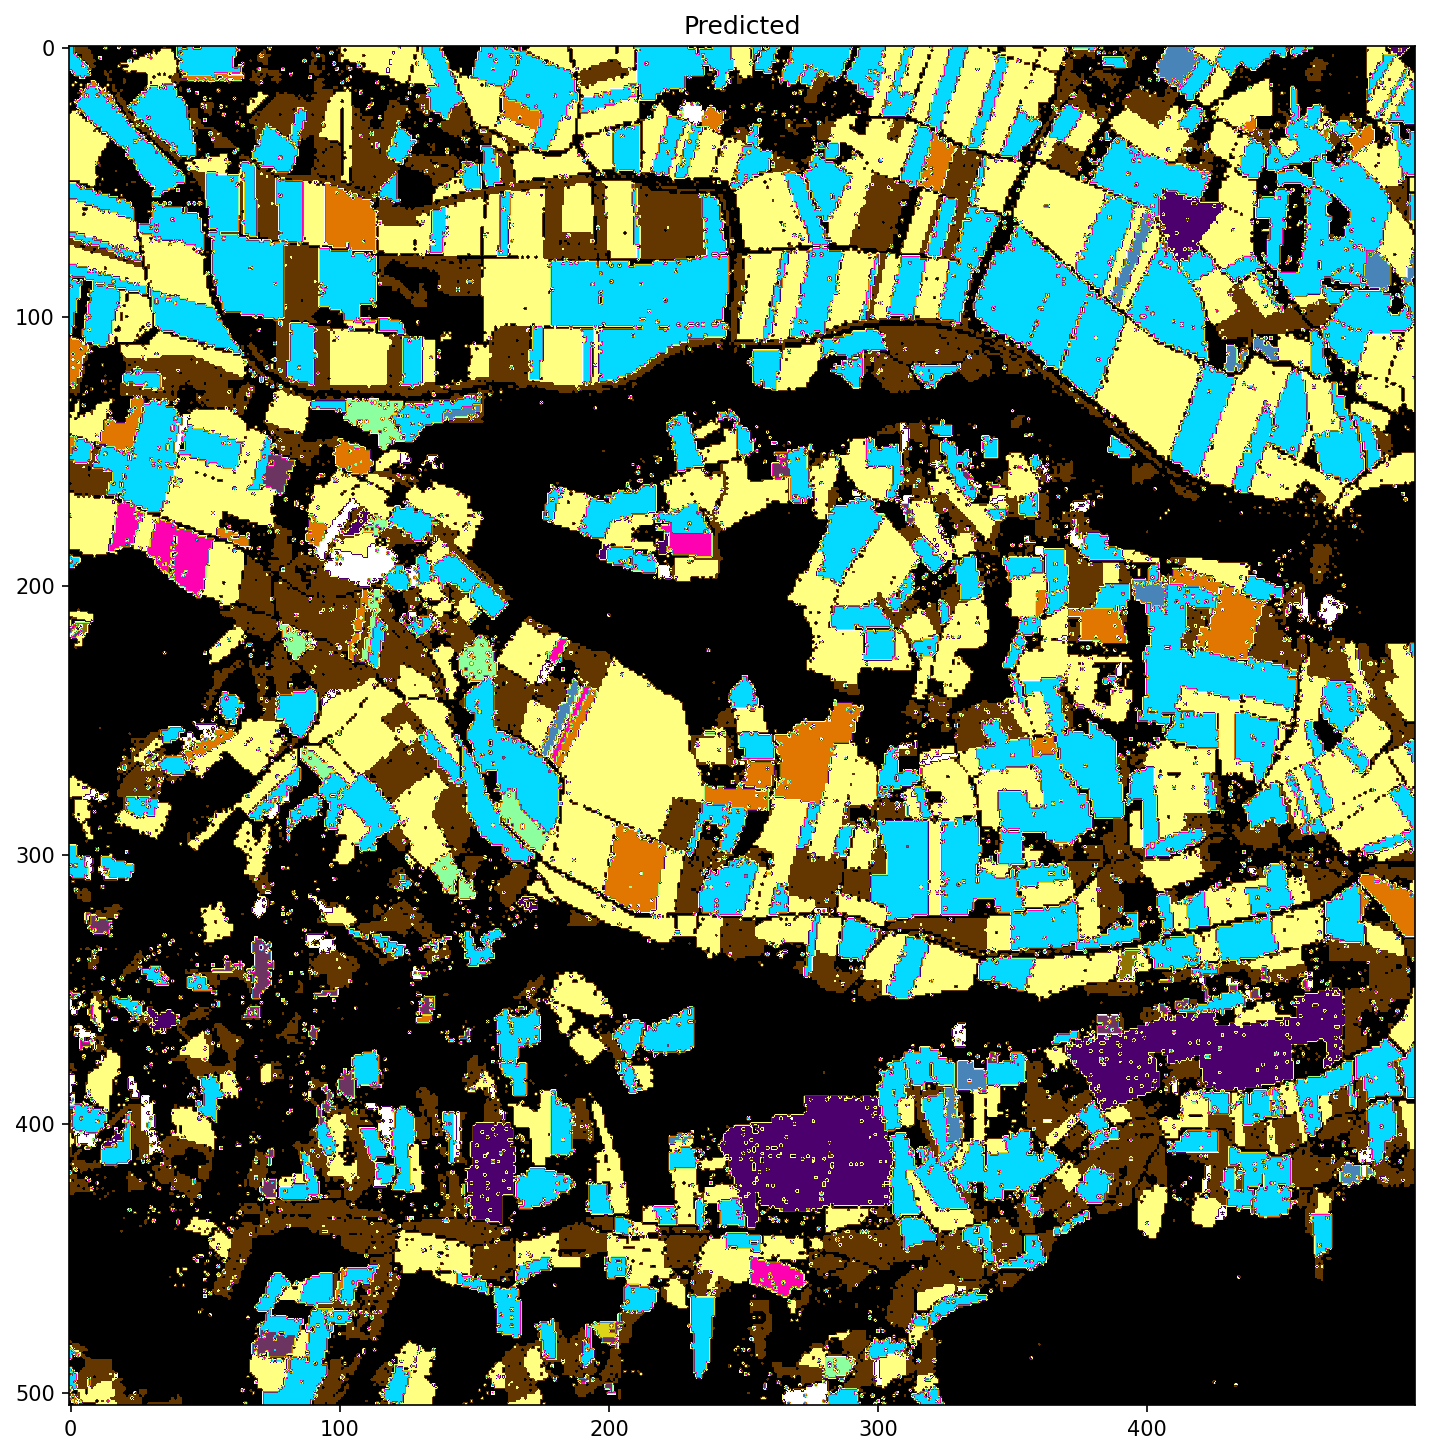

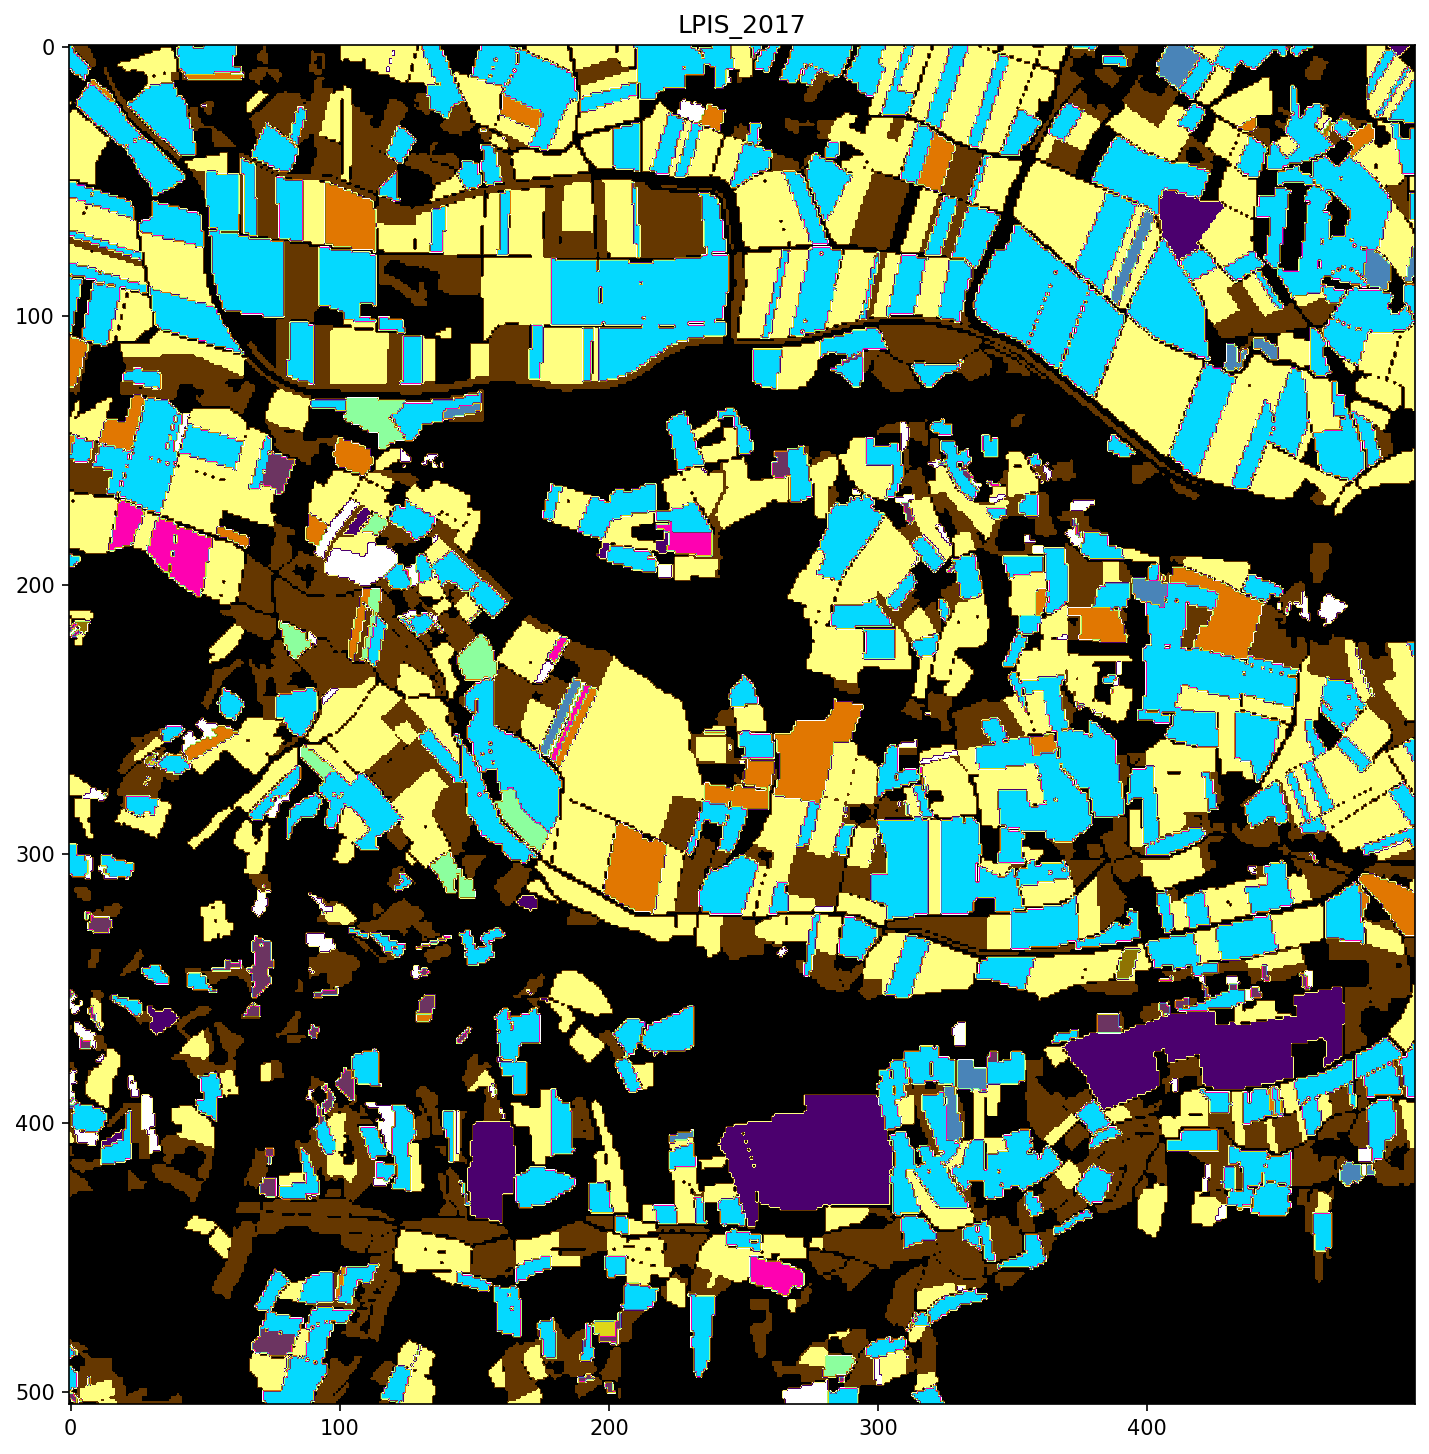

In [21]:
plt.figure(dpi=150, figsize=(12, 12))
plt.title('Predicted')
#add_legend(plt)
plt.imshow(img, cmap=cmap, norm=norm)

plt.figure(dpi=150, figsize=(12, 12))
plt.title('LPIS_2017')
#add_legend(plt)
plt.imshow(lpis, cmap=cmap, norm=norm)
plt.show()